<a href="https://colab.research.google.com/github/Divyanshu-Singh-Chauhan/Image-Forgery-Detection/blob/AnoGANs%2FAutoencoders/AnoGANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
"""
Pipeline :

1. Generate patches from the image.
2. Train an Autoencoder on the full image rather than patches. Patches will be used while testing.
3. Take the Encoder and extract a reduced dimension feature from it.
4. Fit the one class SVM on the extracted feature layer .
5. Predict on the image patches and produce the probability of mask.
6. Generate the masked image back, with the mask probability generated.

"""

'\nPipeline :\n\n1. Generate patches from the image.\n2. Train an Autoencoder on the full image rather than patches. Patches will be used while testing.\n3. Take the Encoder and extract a reduced dimension feature from it.\n4. Fit the one class SVM on the extracted feature layer .\n5. Predict on the image patches and produce the probability of mask.\n6. Generate the masked image back, with the mask probability generated.\n\n'

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout, UpSampling2D
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

from __future__ import print_function, division
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, GaussianNoise
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D
from keras.layers import MaxPooling2D, Concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
from keras import losses
from keras.utils import to_categorical
import argparse
import keras.backend as K
import pickle
import sys 
from keras.optimizers import Adam
from keras.constraints import UnitNorm
try:
    import matplotlib
    matplotlib.use('agg')
    import matplotlib.pyplot as plt
except ImportError:
    print("Failed to import matplotlib!")
    pass
import os
import numpy as np


Using TensorFlow backend.


# AUTOENCODER MODEL - ( DIS + GEN )

In [ ]:
#### Get and resize train images and masks ######
img_rows = 256
img_cols = 256

def get_data(path, train=False):
    ids = os.listdir(path + "/Au")
    X = np.zeros((len(ids), img_rows, img_cols, 3), dtype=np.float32)
    if train:
        y = np.zeros((len(ids), img_rows, img_cols, 1), dtype=np.float32)
    print('Getting and resizing images ... ')
    for n, id_ in tqdm_notebook(enumerate(ids), total=len(ids)):
        # Load images
        try:
          img = load_img(path + '/Au/' + id_, grayscale=False, color_mode='rgb')
          x_img = img_to_array(img)
          x_img = resize(x_img, (img_rows, img_cols, 3), mode='constant', preserve_range=True)
        except UnidentifiedImageError:
          pass    
        # Load masks
        if train:
            mask = img_to_array(load_img(path + '/masks/' + id_, grayscale=False))
            mask = resize(mask, (img_rows, img_cols, 1), mode='constant', preserve_range=True)

        # Save images
        X[n,...] = x_img/255
        if train:
            y[n] = mask / 255
    print('Done!')
    if train:
        return X, y
    else:
        return X

import os
os.chdir('/content/drive/My Drive/Colab Notebooks/CASIA2_COPY/CASIA2_ORIG/data/CASIA2')
!unzip Au.zip -d /content
os.chdir('/content')
!rm /content/Au/Thumbs.db  


In [ ]:
    channels = 3
    img_shape = (img_rows, img_cols, channels)
    #encoded_shape = (16,16,128)


    def build_encoder():
        # Encoder
        print("ENCODER--MODEL")
        encoder = Sequential()
        encoder.add(Conv2D(16, kernel_size=6, strides=1, padding='same', input_shape = img_shape, kernel_constraint=UnitNorm(axis=[0,1,2])))
        encoder.add(BatchNormalization())
        encoder.add(Conv2D(16, kernel_size=5, strides=2, padding='same', kernel_constraint=UnitNorm(axis=[0,1,2])))
        encoder.add(BatchNormalization())
        encoder.add(Conv2D(32, kernel_size=4, strides=2, padding='same', kernel_constraint=UnitNorm(axis=[0,1,2])))
        encoder.add(BatchNormalization())
        encoder.add(Conv2D(64, kernel_size=3, strides=2, padding='same', kernel_constraint=UnitNorm(axis=[0,1,2])))
        encoder.add(BatchNormalization())
        encoder.add(Conv2D(128, kernel_size=2, strides=2, padding='same', kernel_constraint=UnitNorm(axis=[0,1,2])))
    
        encoder.summary()

        return encoder

    def build_decoder():
        # Decoder
        print("DECODER--MODEL")
        decoder = Sequential()
        decoder.add(Conv2DTranspose(64, kernel_size = 2, strides = 2, padding = 'same', input_shape = (16,16,128), kernel_constraint=UnitNorm(axis=[0,1,2])))
        decoder.add(BatchNormalization())
        decoder.add(Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', kernel_constraint=UnitNorm(axis=[0,1,2])))
        decoder.add(BatchNormalization())
        decoder.add(Conv2DTranspose(16, kernel_size=4, strides=2, padding='same', kernel_constraint=UnitNorm(axis=[0,1,2])))
        decoder.add(BatchNormalization())
        decoder.add(Conv2DTranspose(16, kernel_size=5, strides=2, padding='same', kernel_constraint=UnitNorm(axis=[0,1,2])))
        decoder.add(BatchNormalization())
        decoder.add(Conv2DTranspose(3, kernel_size=6, strides=1, padding='same', kernel_constraint=UnitNorm(axis=[0,1,2])))
        decoder.add(Activation(activation='tanh'))

        decoder.summary()

        return decoder

    def build_discriminator():

        print("DISCRiMINATOR--MODEL")

        model = Sequential()


        model.add(Conv2D(15, kernel_size = 5, strides = 1, input_shape = img_shape))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
  
        model.add(Conv2D(16, kernel_size = 2, strides = 2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        
        model.add(Conv2D(32, kernel_size = 4, strides = 1))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        
        model.add(Conv2D(32, kernel_size = 2, strides = 2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())

        model.add(Conv2D(64, kernel_size = 3, strides = 1))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        
        model.add(Conv2D(64, kernel_size = 2, strides = 2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization())
        
        model.add(Flatten())
        model.add(Dense(128))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dense(1))
        model.add(Activation(activation='sigmoid'))
        model.summary()

        return model

In [ ]:
        # img_rows = 128
        # img_cols = 128
        img_shape = (img_rows, img_cols, channels)
        encoded_shape = (8,8,128)
        history = {"d_loss": [], "d_acc": [], "g_loss": [], "g_acc": []}

        optimizer = Adam(0.0005, 0.5)
        # optimizer = RMSprop(lr=0.001, clipvalue=1.0, decay=3e-8)
        # Build and compile the discriminator
        discriminator = build_discriminator()
        discriminator.trainable = False
        discriminator.compile(loss='binary_crossentropy',
            optimizer=optimizer,
            metrics=['accuracy'])

        # Build and compile the encoder / decoder
        encoder = build_encoder()
        decoder = build_decoder()

        img = Input(shape=img_shape)
        # The generator takes the image, encodes it and reconstructs it
        # from the encoding
        encoded_repr = encoder(img)
        reconstructed_img = decoder(encoded_repr)
        
        print("The shape of recons-image is :",reconstructed_img.shape)
        autoencoder = Model(img, reconstructed_img)
        autoencoder.compile(loss='mse', optimizer = optimizer)
        # For the adversarial_autoencoder model we will only train the generator
        #self.discriminator.trainable = False

        print("ALERT!!!!!!! ERROR FROM HERE")
        # The discriminator determines validity of the encoding
        validity = discriminator(reconstructed_img)      

        # The adversarial_autoencoder model  (stacked generator and discriminator)
        adversarial_autoencoder = Model(img, [reconstructed_img, validity])
        adversarial_autoencoder.compile(loss=['mse', 'binary_crossentropy'], loss_weights=[0.98, 0.02], optimizer= optimizer, metrics=['accuracy'])
        adversarial_autoencoder.summary()
        print(adversarial_autoencoder.metrics_names)

DISCRiMINATOR--MODEL
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 252, 252, 15)      1140      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 252, 252, 15)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 252, 252, 15)      60        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 126, 126, 16)      976       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 126, 126, 16)      0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 126, 126, 16)      64        
_________________________________________________________________
conv2d_3 (Conv2D)            (Non

In [ ]:
    def pretrain_ae(data, iterations, batch_size):
        history = {'loss': []}
 
        for it in range(iterations):
            idx = np.random.randint(0, data.shape[0], batch_size)
            imgs = data[idx]
            train_loss = autoencoder.train_on_batch(imgs, imgs)
            history['loss'].append(train_loss)

            print("[Pretrain AE]---It {}/{} | AE loss: {:.4f}".format(it, iterations, train_loss),flush=True)

        plt.figure()
        plt.title("Pretrain AE")
        plt.xlabel("Iter")
        plt.ylabel("Loss")
        step = len(history['loss']) // 10 if len(history['loss']) > 1000 else 1
        plt.plot(np.arange(len(history['loss'][::step])), history['loss'][::step])
        plt.savefig("pretrain ae")
        
        autoencoder.save_weights("/content/drive/My Drive/weights/AnoGANs/autoencoder_unitnorm.h5")

In [ ]:
    def pretrain_discriminator(data, iterations, batch_size):
        half_batch = batch_size // 2
        fake = np.zeros((half_batch, 1))
        valid = np.ones((half_batch, 1))
        history = {'loss': [], 'acc': []}
  
        for it in range(iterations):
            idx = np.random.randint(0, data.shape[0], half_batch)
            imgs = data[idx]
            generated_imgs = autoencoder.predict(imgs)
            
        
            # Train the discriminator
            d_loss_real = discriminator.train_on_batch(imgs, valid)
            d_loss_fake = discriminator.train_on_batch(generated_imgs, fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            history['loss'].append(d_loss[0])
            history['acc'].append(d_loss[1])
            print("[Pretrain Discriminator]---it {}/{} | loss: {:.4f} | acc {:.2f}".format(it, iterations, d_loss[0], d_loss[1]), flush=True)
        
        plt.figure()
        plt.title("Pretrain Discriminator")
        plt.xlabel("Iter")
        plt.ylabel("Loss")
        step = len(history['loss']) // 10 if len(history['loss']) > 1000 else 1
        plt.plot(np.arange(len(history['loss'][::step])), history['loss'][::step])
        plt.savefig("pretrain discriminator")

        discriminator.save_weights("/content/drive/My Drive/weights/AnoGANs/discriminator_unitnorm.h5")

In [ ]:
def sample_images(epoch,images):
      rows, cols = 5, 5
      if not os.path.isdir("/content/drive/My Drive/Colab Notebooks/AnoGANs/AE_images_unitnorm2"):
        os.mkdir("/content/drive/My Drive/Colab Notebooks/AnoGANs/AE_images_unitnorm2")
      imgs = autoencoder.predict(images)
      print("The shape of img is : ", imgs.shape)
        #RESCALE IMAGES
      imgs = 0.5*imgs + 0.5

      fig, axs = plt.subplots(rows,cols)
      idx = 0
      for i in range(rows):
        for j in range(cols):
          axs[i,j].imshow(imgs[idx])
          axs[i,j].axis('off')
          idx += 1
          fig.savefig("/content/drive/My Drive/Colab Notebooks/AnoGANs/AE_images_unitnorm2/%d.png" %epoch)
      plt.close()        

In [ ]:
    def save_model():
        adversarial_autoencoder.save_weights("/content/drive/My Drive/weights/AnoGANs/adversarial_ae2.h5")
        discriminator.save_weights("/content/drive/My Drive/weights/AnoGANs/discriminator2.h5")
        autoencoder.save_weights("/content/drive/My Drive/weights/AnoGANs/autoencoder2.h5")

In [ ]:
    def train(iterations, pre_dis_iterations, pre_ae_iterations, batch_size=64, sample_interval=100, tolerance=20):

        # Load the dataset
        #X_train = get_data(train_path, train=False)
        # X_train = np.load("data.npy")
        # mean = np.mean(X_train, axis=(0,1,2,3))
        # std  = np.std(X_train, axis=(0,1,2,3))
        # X_train = (X_train.astype(np.float32) - mean) / (std + 1e-7)
        print("Start training on {} images".format(X_train.shape[0]))

        if os.path.isfile("/content/drive/My Drive/weights/AnoGANs/discriminator_unitnorm.h5"):
            discriminator.load_weights("/content/drive/My Drive/weights/AnoGANs/discriminator_unitnorm.h5")
            print("Loaded discriminator weights!")
        elif pre_dis_iterations > 0:
            pretrain_discriminator(X_train, pre_dis_iterations, batch_size)
            print("Discriminator Weights Initialised")
        
        
        if os.path.isfile("/content/drive/My Drive/weights/AnoGANs/autoencoder_unitnorm.h5"):
            autoencoder.load_weights("/content/drive/My Drive/weights/AnoGANs/autoencoder_unitnorm.h5")
            print("Loaded autoencoder weights!")
        elif pre_ae_iterations > 0:
            pretrain_ae(X_train, pre_ae_iterations, batch_size)
            print("Autoencoder Weights Initialised")

        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        half_batch = batch_size // 2
        half_valid = np.ones((half_batch, 1))
        half_fake = np.ones((half_batch, 1))
        for it in range(iterations):
            # ---------------------
            #  Train Discriminator
            # ---------------------
            print("The epoch is : ", it)
            imgs = X_train[np.random.randint(0, X_train.shape[0], half_batch)]
          
            generated_imgs = autoencoder.predict(imgs)
            
            
            d_loss_real = discriminator.train_on_batch(imgs, half_valid)
            d_loss_fake = discriminator.train_on_batch(generated_imgs, half_fake)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            history['d_loss'].append(d_loss[0])
            history['d_acc'].append(d_loss[1] * 100)

            # ---------------------
            #  Train Generator
            # ---------------------
            
            imgs = X_train[np.random.randint(0, X_train.shape[0], batch_size)]
            g_loss = adversarial_autoencoder.train_on_batch(imgs, [imgs, valid])
            history['g_loss'].append(g_loss[0])
            history['g_acc'].append(g_loss[-1]*100)
            print("[Training Adversarial AE]---epoch {}/{} | d_loss: {:.4f} | d_acc: {:.2f} | g_loss: {:.4f} | g_acc: {:.2f}".format(it, iterations, d_loss[0], d_loss[1]*100, g_loss[0], g_loss[-1]*100),flush=True)
            
            adversarial_autoencoder.save_weights("/content/drive/My Drive/weights/AnoGANs/aae_unitnorm.h5")
            #If at save interval => save generated image samples
            if it % sample_interval == 0:
                # Select a random half batch of images
                idx = np.random.randint(0, X_train.shape[0], batch_size//2)
                imgs = X_train[idx]
                sample_images(it, imgs)


In [ ]:
train_path = '/content'  
#X_train = get_data(train_path, train=False)
train(iterations=1000, pre_ae_iterations = 1000, pre_dis_iterations = 1000, batch_size = 64)

Start training on 7491 images
Loaded discriminator weights!
Loaded autoencoder weights!
The epoch is :  0
[Training Adversarial AE]---epoch 0/1000 | d_loss: 0.4740 | d_acc: 82.81 | g_loss: 0.1791 | g_acc: 62.50
The shape of img is :  (32, 256, 256, 3)
The epoch is :  1
[Training Adversarial AE]---epoch 1/1000 | d_loss: 0.5544 | d_acc: 71.88 | g_loss: 0.1641 | g_acc: 70.31
The epoch is :  2
[Training Adversarial AE]---epoch 2/1000 | d_loss: 0.4871 | d_acc: 78.12 | g_loss: 0.1777 | g_acc: 92.19
The epoch is :  3
[Training Adversarial AE]---epoch 3/1000 | d_loss: 0.4248 | d_acc: 76.56 | g_loss: 0.1765 | g_acc: 90.62
The epoch is :  4
[Training Adversarial AE]---epoch 4/1000 | d_loss: 0.4835 | d_acc: 76.56 | g_loss: 0.1525 | g_acc: 96.88
The epoch is :  5
[Training Adversarial AE]---epoch 5/1000 | d_loss: 0.5533 | d_acc: 75.00 | g_loss: 0.1416 | g_acc: 92.19
The epoch is :  6
[Training Adversarial AE]---epoch 6/1000 | d_loss: 0.3843 | d_acc: 82.81 | g_loss: 0.1324 | g_acc: 98.44
The epoch 

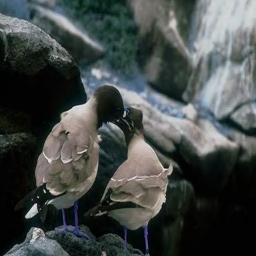

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
#X_train = X_train*255
cv2_imshow(X_train[2])

In [ ]:
save_model()

# TRAINING THE ONE CLASS SVM AND SAVING THE PARAS OF THE SVM 

In [ ]:
#### LOADING THE TRAINED WEIGHTS ####
import os 
if os.path.isfile("/content/drive/My Drive/weights/AnoGANs/autoencoder2.h5"):
  autoencoder.load_weights("/content/drive/My Drive/weights/AnoGANs/autoencoder2.h5")


##### Extracting the Features from the dataset #####  
def get_features(data):
    preds = encoder.predict(data)
    resized = np.resize(preds,(data.shape[0],preds.shape[1]*preds.shape[2]*preds.shape[3]))
    return resized
  
  
features = get_features(X_train)


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn import svm
from sklearn.mixture import GaussianMixture
from sklearn.isotonic import IsotonicRegression


# Apply standard scaler to output from resnet50
ss = StandardScaler()
ss.fit(features)
features = ss.transform(features)                               #

# Take PCA to reduce feature space dimensionality
pca = PCA(n_components=512, whiten=True)
pca = pca.fit(features)
print('Explained variance percentage = %0.2f' % sum(pca.explained_variance_ratio_))
features = pca.transform(features)

# Train classifier and obtain predictions for OC-SVM
oc_svm_clf = svm.OneClassSVM(gamma=0.001, kernel='rbf', nu=0.08)  # Obtained using grid search
if_clf = IsolationForest(contamination=0.08, max_features=1.0, max_samples=1.0, n_estimators=40)  # Obtained using grid search

### FITTING ON THE METHOD ###

oc_svm_clf.fit(features)
if_clf.fit(features)

#### Saving the Parameters to be used later ####
filename = '/content/drive/My Drive/weights/AnoGANs/ocsvm-unitnorm2-512.sav'     
pickle.dump(oc_svm_clf,open(filename,'wb')) 

filename = '/content/drive/My Drive/weights/AnoGANs/if-unitnorm2-512.sav'
pickle.dump(if_clf,open(filename,'wb'))

# Further compute accuracy, precision and recall for the two predictions sets obtained


Explained variance percentage = 0.73


In [ ]:
##### PREDICTION ON TRAINING SET ######## 
filename1 = '/content/drive/My Drive/weights/AnoGANs/ocsvm-unitnorm2-512.sav'  
filename2 = '/content/drive/My Drive/weights/AnoGANs/if-unitnorm2-512.sav'
oc_svm_clf = pickle.load(open(filename1,'rb'))
if_clf = pickle.load(open(filename2,'rb'))

def prediction(features):

  #oc_svm_preds = oc_svm_clf.predict(X_test)                     #############################
  #if_preds = if_clf.predict(X_test)                             #############################
  oc_svm_preds = oc_svm_clf.predict(features)
  #print("Prediction due to One Class SVM are : ")
  #print(oc_svm_preds)
  #print("          ")
  if_preds = if_clf.predict(features)
  #print("Prediction due to Isolation Forest are : ")
  #print(if_preds)

  return oc_svm_preds, if_preds

oc_svm_preds, if_preds = prediction(features)  

In [ ]:
count = 0
cnt = 0
for i in oc_svm_preds:
  if i == 1:
    count+=1

for j in  if_preds:
  if j == 1:
    cnt +=1

print("The correctly predicted for OCSVM are: ", count,"/",len(oc_svm_preds))   
print("The correctly predicted for IF are: ", cnt,"/",len(if_preds))     

The correctly predicted for OCSVM are:  6894 / 7491
The correctly predicted for IF are:  6891 / 7491


In [ ]:
"""
ONE CLASS LEARNING WITH GMM MODELS 
"""

'\nONE CLASS LEARNING WITH GMM MODELS \n'

# RECONSTRUCTING THE IMAGE BINARY MASK

In [ ]:
"""

WE HAVE A LIST WITH THE LABELS AND THE CORRESPONDING TOP-LEFT COORDINATE OF THE IMAGE PATCH

"""

'\nWE HAVE A LIST WITH THE LABELS AND THE CORRESPONDING TOP-LEFT COORDINATE OF THE IMAGE PATCH\n\n'

In [ ]:
import cv2
image = cv2.imread('/content/tampered_casia2.jpg',1)
stepsize = 64
(winW,winH) = (64,64)

In [ ]:
##DEFINING THE SLIDING WINDOW
def sliding_window(image, stepSize, windowSize):
	# slide a window across the image
	for y in range(0, image.shape[0], stepSize):
		for x in range(0, image.shape[1], stepSize):
			# yield the current window
			yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

In [ ]:
###ARRAY IS GENERATED WITH ROWS CORRESPONDING TO IMAGE OF THE EACH BLOCK
arr_flat = []
arr = []
coord_arr = []
def arr_generate(image):

  for (x, y, window) in sliding_window(image, stepSize=stepsize, windowSize=(winW, winH)):
    if window.shape[0]!=winH or window.shape[1]!= winW:
      continue 
    # if count == 1:
    #   arr_flat = []
    #   count +=1
    coord_arr.append((x,y)) #### storing the top-left coordinates of each block
    window = window.tolist()
    arr_flat.append(window)  

  return arr_flat

arr = arr_generate(image)
print(len(arr))
print(len(coord_arr))  

In [ ]:
arr1 = np.array(arr)
arr1.shape

(24, 64, 64, 3)

In [ ]:
#### LOADING THE TRAINED WEIGHTS ####
import os 
if os.path.isfile("/content/drive/My Drive/weights/AnoGANs/autoencoder.h5"):
  autoencoder.load_weights("/content/drive/My Drive/weights/AnoGANs/autoencoder.h5")


##### Extracting the Features #####  
def get_features(data):
    preds = encoder.predict(data)
    resized = np.resize(preds,(data.shape[0],preds.shape[1]*preds.shape[2]*preds.shape[3]))
  return resized
  
features = get_features(arr1)
len(features)

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest
from sklearn import svm
from sklearn.mixture import GaussianMixture
from sklearn.isotonic import IsotonicRegression

def transform(features,n_components = 20):

  # Apply standard scaler to output from resnet50
  ss = StandardScaler()
  ss.fit(features)
  features = ss.transform(features)

  # Take PCA to reduce feature space dimensionality
  pca = PCA(n_components=n_components, whiten=True)
  pca = pca.fit(features)
  print('Explained variance percentage = %0.2f' % sum(pca.explained_variance_ratio_))
  features = pca.transform(features)

  return features

transformed_features = transform(features,20)


Explained variance percentage = 0.99


In [ ]:
def predict(feat):
  # Train classifier and obtain predictions for OC-SVM
  oc_svm_clf = svm.OneClassSVM(gamma=0.001, kernel='rbf', nu=0.08)  # Obtained using grid search
  if_clf = IsolationForest(contamination=0.08, max_features=1.0, max_samples=1.0, n_estimators=40)  # Obtained using grid search
  filename1 = '/content/drive/My Drive/weights/AnoGANs/ocsvm-512.sav'
  filename2 = '/content/drive/My Drive/weights/AnoGANs/if-512.sav'
  oc_svm_clf = pickle.load(open(filename1,'rb'))
  if_clf = pickle.load(open(filename2,'rb'))
  oc_svm_preds = oc_svm_clf.predict(feat)
  if_preds = if_clf.predict(feat)
  
  return oc_svm_preds,if_preds

oc_svm_preds,if_preds = predict(transformed_features)  

In [ ]:
print("The labels for OCSVM are : ")
print(oc_svm_preds)
print(" ")
print("The labels for If are : ")
print(if_preds)

[ 1  1  1 -1 -1 -1  1  1  1  1 -1  1 -1 -1 -1  1  1 -1 -1  1  1 -1 -1  1]


In [ ]:
tampered_ids = [ i for i,val in enumerate(oc_svm_preds) if val == -1]
tampered_coord = []
for i in tampered_ids:
  tampered_coord.append(coord_arr[i])

print(len(tampered_coord))

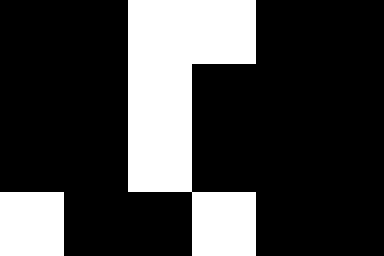

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
### creating an array of the same size as that of resized input image
duplication = np.zeros((image.shape[0],image.shape[1]))

### Giving values to the duplicated regions as 255
for coord in tampered_coord:
  duplication[coord[0]:coord[0]+winW,coord[1]:coord[1]+winH] = 255 

cv2_imshow(duplication)  

In [ ]:
import cv2
img = cv2.imread('/content/Aadhar_updated.png',1)
img = cv2.resize(img, (256,256))
img = np.expand_dims(img,axis = 0)
print(img.shape)
result = encoder.predict(img)

(1, 256, 256, 3)


In [ ]:
result[0,0]

array([[ 2961.8743  , -3617.7056  , -4328.385   , ...,  1444.5137  ,
        -1436.8414  ,  1782.7739  ],
       [  455.93582 ,  -748.485   , -1177.9141  , ...,   134.7104  ,
           87.459816,    33.193874],
       [   23.438066,  -544.96106 ,  -648.67194 , ...,   350.03238 ,
         -172.25238 ,  -312.33716 ],
       ...,
       [  329.27078 ,  -790.49255 , -1321.1519  , ...,   140.54482 ,
         -216.4827  ,  -204.25633 ],
       [  325.8817  ,  -778.12335 , -1286.814   , ...,   155.12305 ,
         -204.34343 ,  -172.42648 ],
       [  565.01917 ,  -655.67554 , -1238.6525  , ...,  -158.60501 ,
          255.65948 ,   211.03104 ]], dtype=float32)

In [ ]:
autoencoder.load_weights("/content/drive/My Drive/weights/AnoGANs/autoencoder1.h5")

In [ ]:
result = encoder.predict(img)
result[0,0]

array([[ 2961.8743  , -3617.7056  , -4328.385   , ...,  1444.5137  ,
        -1436.8414  ,  1782.7739  ],
       [  455.93582 ,  -748.485   , -1177.9141  , ...,   134.7104  ,
           87.459816,    33.193874],
       [   23.438066,  -544.96106 ,  -648.67194 , ...,   350.03238 ,
         -172.25238 ,  -312.33716 ],
       ...,
       [  329.27078 ,  -790.49255 , -1321.1519  , ...,   140.54482 ,
         -216.4827  ,  -204.25633 ],
       [  325.8817  ,  -778.12335 , -1286.814   , ...,   155.12305 ,
         -204.34343 ,  -172.42648 ],
       [  565.01917 ,  -655.67554 , -1238.6525  , ...,  -158.60501 ,
          255.65948 ,   211.03104 ]], dtype=float32)